# Group 3: Topic Modeling on Customer Feedback

## Members:
1. Scolastica Nzyoki
2. Mercy Njambi
3. Brenda Murage
4. Purity Njau
5. Collins Too

## Data Source:
Amazon US Customer Reviews Dataset from Kaggle


# Introduction

In this notebook, we aim to analyze customer feedback from Amazon US Customer Reviews using topic modeling techniques. The objective is to extract and visualize common themes and topics within the reviews, which can provide valuable insights into customer sentiments and preferences. These insights can be utilized to enhance product features, improve customer satisfaction, and inform marketing strategies.



# Import Necessary Libraries and Download NLTK Data

This cell imports all the necessary libraries for file handling, data manipulation, text processing, and visualization.
It ensures that the required NLTK data (stopwords and wordnet) is downloaded.

In [14]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import download
from gensim import corpora, models
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Ensure necessary NLTK data is downloaded
download('stopwords')
download('wordnet')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\v-puritynjau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\v-puritynjau\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Define File Selection Function
This function uses tkinter to create a file selection dialog, allowing the user to select multiple files.
It prints the selected file paths.

In [15]:
def select_file():
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    root.attributes('-topmost', True)  # Ensure root window is on top
    file_paths = filedialog.askopenfilenames(parent=root)
    if file_paths:
        return file_paths
    else:
        return None

file_paths = select_file()
print(f'Selected files: {file_paths}')



Selected files: ('C:/Users/v-puritynjau/Downloads/archive/amazon_reviews_us_Digital_Software_v1_00.tsv',)


#  Define Data Loading and Preprocessing Functions

load_data loads the data from a file.
preprocess_text cleans the text by removing non-alphabetic characters, converting to lowercase, removing stopwords, and lemmatizing the words.
The example usage demonstrates loading and preprocessing the first selected file and prints the first few rows of the DataFrame.

In [16]:
def load_data(file_path):
    return pd.read_csv(file_path, sep='\t', on_bad_lines='skip')

def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z]', ' ', text)
        text = text.lower()
        stop_words = set(stopwords.words('english')) | {'br'}
        words = text.split()
        words = [word for word in words if word not in stop_words]
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(words)
    else:
        return ""

# Example usage with the first file (if any)
if file_paths:
    df = load_data(file_paths[0])
    df['cleaned_review'] = df['review_body'].apply(preprocess_text)
    print(df.head())



  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     17747349  R2EI7QLPK4LF7U  B00U7LCE6A       106182406   
1          US     10956619  R1W5OMFK1Q3I3O  B00HRJMOM4       162269768   
2          US     13132245   RPZWSYWRP92GI  B00P31G9PQ       831433899   
3          US     35717248  R2WQWM04XHD9US  B00FGDEPDY       991059534   
4          US     17710652  R1WSPK2RA2PDEF  B00FZ0FK0U       574904556   

                                       product_title  product_category  \
0                           CCleaner Free [Download]  Digital_Software   
1                 ResumeMaker Professional Deluxe 18  Digital_Software   
2                          Amazon Drive Desktop [PC]  Digital_Software   
3         Norton Internet Security 1 User 3 Licenses  Digital_Software   
4  SecureAnywhere Intermet Security Complete 5 De...  Digital_Software   

   star_rating  helpful_votes  total_votes vine verified_purchase  \
0            4              0            

In [17]:
#Dimensions of the dataset
df.shape

(101836, 16)

In [18]:
#Summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101836 entries, 0 to 101835
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        101836 non-null  object
 1   customer_id        101836 non-null  int64 
 2   review_id          101836 non-null  object
 3   product_id         101836 non-null  object
 4   product_parent     101836 non-null  int64 
 5   product_title      101836 non-null  object
 6   product_category   101836 non-null  object
 7   star_rating        101836 non-null  int64 
 8   helpful_votes      101836 non-null  int64 
 9   total_votes        101836 non-null  int64 
 10  vine               101836 non-null  object
 11  verified_purchase  101836 non-null  object
 12  review_headline    101836 non-null  object
 13  review_body        101831 non-null  object
 14  review_date        101831 non-null  object
 15  cleaned_review     101836 non-null  object
dtypes: int64(5), object(

In [19]:
#Descriptive statistics of the data
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,1.018360e+05,1.018360e+05,101836.000000,101836.000000,101836.000000
mean,2.985629e+07,5.384349e+08,3.539662,2.455026,3.148435
std,1.542642e+07,2.852067e+08,1.640100,28.290384,29.453331
min,1.022900e+04,2.097090e+05,1.000000,0.000000,0.000000
25%,1.579766e+07,2.843240e+08,2.000000,0.000000,0.000000
50%,2.978113e+07,6.087201e+08,4.000000,0.000000,0.000000
75%,4.428885e+07,8.074820e+08,5.000000,1.000000,2.000000
max,5.309639e+07,9.998991e+08,5.000000,5363.000000,5465.000000


# Process the File and Perform Topic Modeling

This function preprocesses the data and performs LDA topic modeling.
It prints the top words for each topic to help interpret the topics.
It processes the first selected file and stores the returned variables for further use.

In [20]:
def process_file(file_path):
    df = load_data(file_path)
    df = df[['review_body']].dropna()
    df['cleaned_review'] = df['review_body'].apply(preprocess_text)

    text_data = [text.split() for text in df['cleaned_review']]
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]

    num_topics = 5
    ldamodel = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1)
    topics = ldamodel.print_topics(num_words=4)
    for topic in topics:
        print(topic)

    return df, text_data, dictionary, corpus, ldamodel, num_topics

if file_paths:
    df, text_data, dictionary, corpus, ldamodel, num_topics = process_file(file_paths[0])


(0, '0.017*"download" + 0.014*"amazon" + 0.014*"software" + 0.013*"product"')
(1, '0.033*"norton" + 0.029*"product" + 0.028*"computer" + 0.020*"year"')
(2, '0.015*"program" + 0.014*"use" + 0.010*"software" + 0.010*"like"')
(3, '0.038*"quicken" + 0.020*"version" + 0.015*"account" + 0.011*"year"')
(4, '0.040*"tax" + 0.034*"year" + 0.019*"software" + 0.018*"state"')


# Generate Word Clouds for Each Topic

This cell generates word clouds for each topic.
Word clouds visually represent the most important words for each topic, with larger words indicating higher importance.


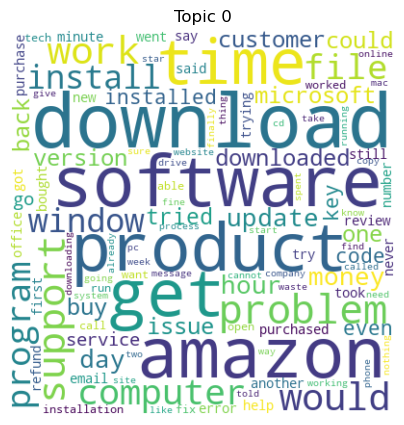

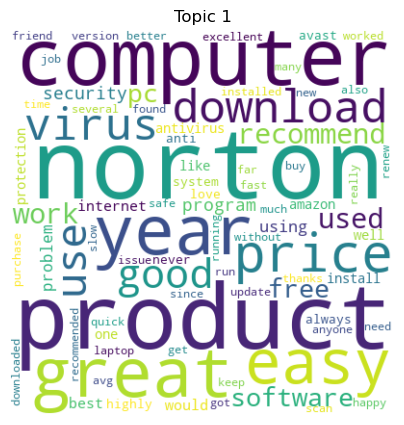

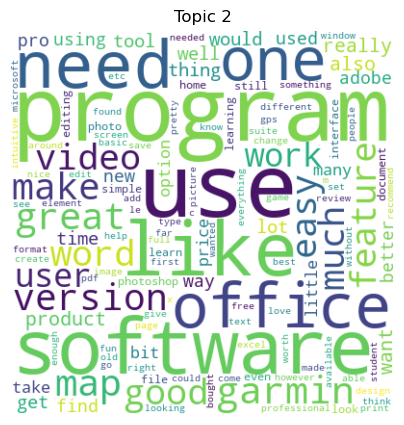

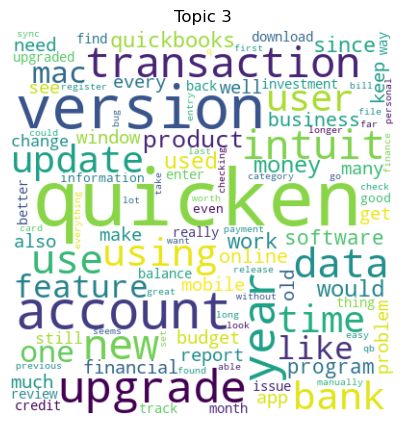

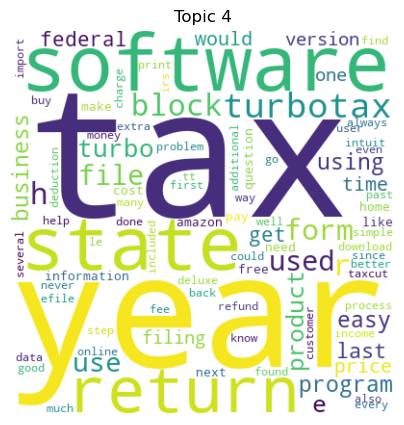

In [21]:
def generate_wordclouds(ldamodel, num_topics):
    for i in range(num_topics):
        topic_words = dict(ldamodel.show_topic(i, 200))
        wordcloud = WordCloud(width=400, height=400,
                              background_color='white',
                              stopwords=stopwords.words('english'),
                              min_font_size=10).generate_from_frequencies(topic_words)

        plt.figure(figsize=(5, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {i}")
        plt.show()

generate_wordclouds(ldamodel, num_topics)


# Plot Distribution of Document Word Counts by Dominant Topic

This cell plots the distribution of word counts for documents where each topic is dominant.
It helps in understanding the length of documents associated with each topic.

C:\Users\v-puritynjau\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


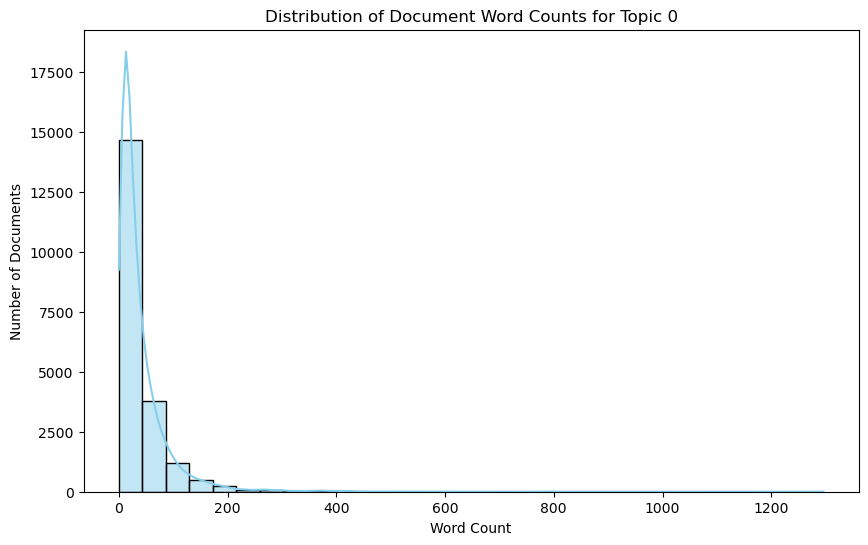

C:\Users\v-puritynjau\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


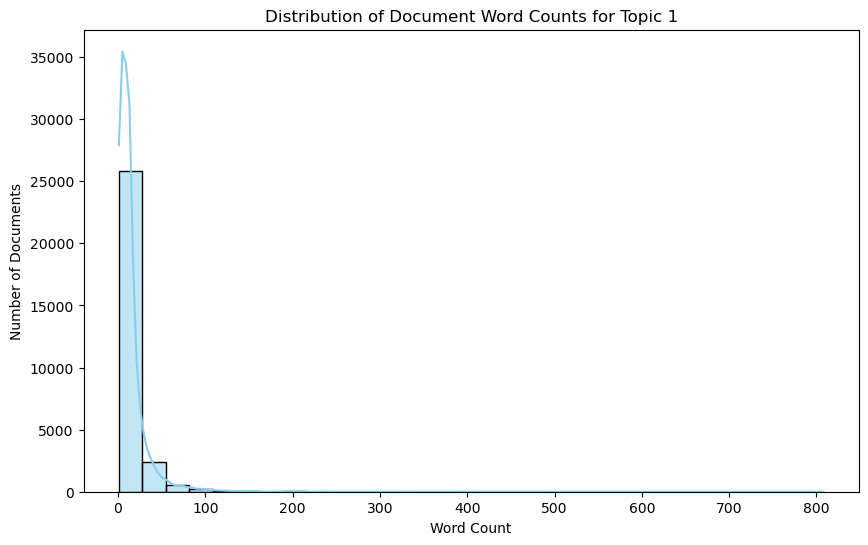

C:\Users\v-puritynjau\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


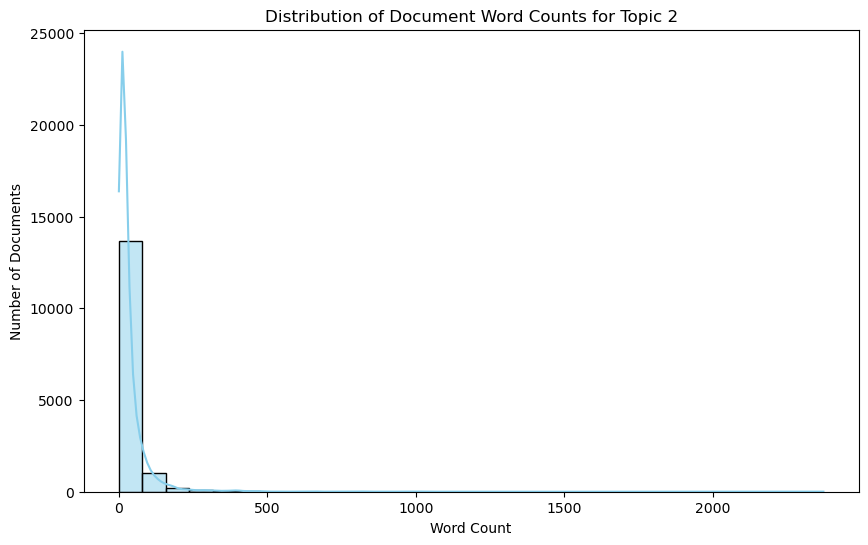

C:\Users\v-puritynjau\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


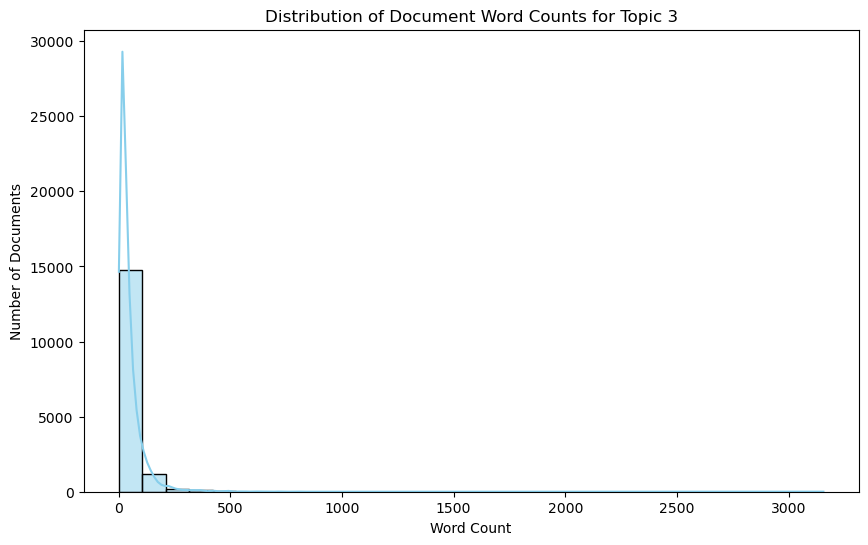

C:\Users\v-puritynjau\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


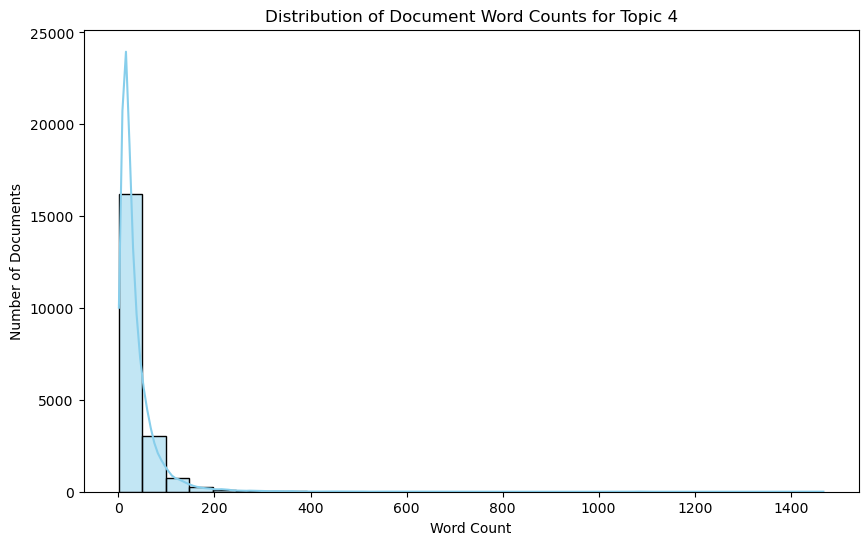

In [22]:
def plot_word_count_distribution(ldamodel, corpus, text_data, num_topics):
    topic_word_counts = {i: [] for i in range(num_topics)}

    for doc_id, doc in enumerate(corpus):
        doc_topics = ldamodel.get_document_topics(doc, minimum_probability=0)
        doc_topics = sorted(doc_topics, key=lambda x: -x[1])
        dominant_topic, _ = doc_topics[0]
        word_count = len(text_data[doc_id])
        topic_word_counts[dominant_topic].append(word_count)

    for i in range(num_topics):
        plt.figure(figsize=(10, 6))
        sns.histplot(topic_word_counts[i], bins=30, kde=True, color='skyblue')
        plt.title(f'Distribution of Document Word Counts for Topic {i}')
        plt.xlabel('Word Count')
        plt.ylabel('Number of Documents')
        plt.show()

plot_word_count_distribution(ldamodel, corpus, text_data, num_topics)


# Plot Topic Distribution Across All Documents

This cell plots the distribution of topics across all documents.
It shows how prevalent each topic is within the dataset.

C:\Users\v-puritynjau\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


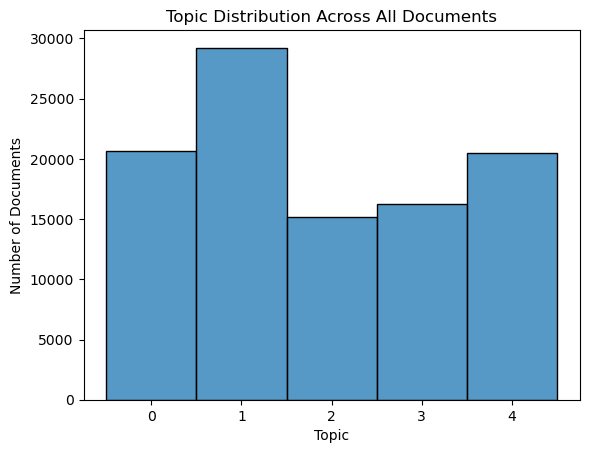

In [23]:
def plot_topic_distribution(ldamodel, corpus, num_topics):
    topic_distribution = [max(ldamodel[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]
    sns.histplot(topic_distribution, bins=num_topics, kde=False, discrete=True)
    plt.title('Topic Distribution Across All Documents')
    plt.xlabel('Topic')
    plt.ylabel('Number of Documents')
    plt.xticks(range(num_topics))
    plt.show()

plot_topic_distribution(ldamodel, corpus, num_topics)


# Compute and Plot Coherence Scores

This cell calculates and plots the coherence scores for different numbers of topics.
Coherence scores help determine the optimal number of topics by measuring how interpretable the topics are.

In [ ]:
def plot_coherence_scores(dictionary, corpus, text_data):
    coherence_values = []
    topic_range = range(2, 10)
    for num in topic_range:
        model = models.LdaModel(corpus, num_topics=num, id2word=dictionary, passes=1)
        coherence_model = CoherenceModel(model=model, texts=text_data, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    plt.figure(figsize=(10, 6))
    plt.plot(topic_range, coherence_values, marker='o')
    plt.title('Coherence Scores by Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(topic_range)
    plt.show()

plot_coherence_scores(dictionary, corpus, text_data)


# Compute and Visualize TF-IDF Bar Plot 
This cell computes the TF-IDF(Term Frequency-Inverse Document Frequency) scores for the top 15 terms in the dataset.
It visualizes these scores using a frequency chart, showing the importance of terms across different documents.

It is a numerical statistic that is intended to reflect the importance of a word in a document relative to a collection of documents (corpus). The TF-IDF value increases proportionally to the number of times a word appears in a document but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

Interpretation of TF-IDF Values:
High TF-IDF: A high value indicates that the term is important to the document and relatively rare across the corpus. This suggests that the term is particularly relevant to the specific document.
Low TF-IDF: A low value indicates that the term is either not important to the document or common across the corpus, which makes it less useful for distinguishing between documents.



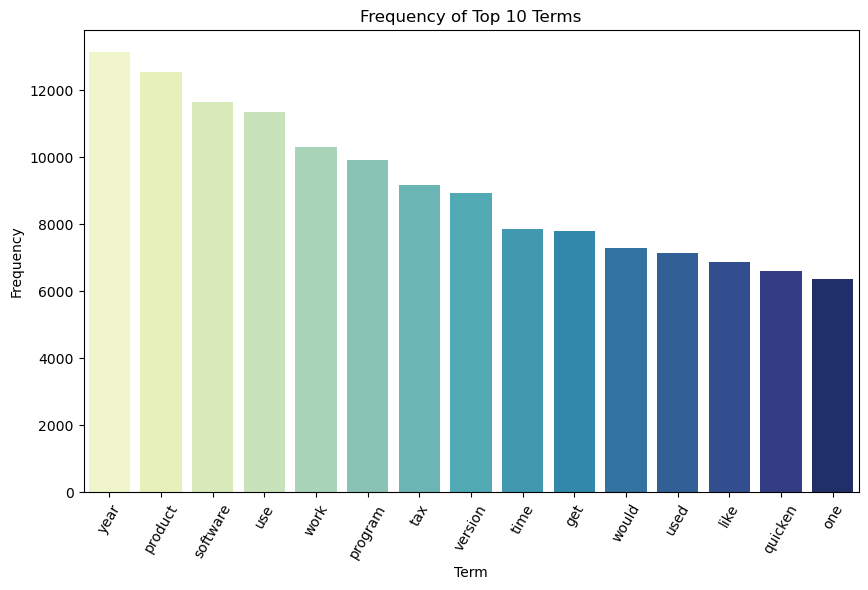

In [25]:
def plot_tfidf_frequency(df):
    cleaned_reviews = df['cleaned_review'].tolist()
    vectorizer = TfidfVectorizer(max_features=15)
    tfidf_matrix = vectorizer.fit_transform(cleaned_reviews).toarray()
    terms = vectorizer.get_feature_names_out()
    
    # Calculate the frequency of each term
    term_frequencies = tfidf_matrix.sum(axis=0)
    
    # Create a DataFrame for term frequencies
    tfidf_df = pd.DataFrame({'Term': terms, 'Frequency': term_frequencies})
    
    # Sort the DataFrame by frequency
    tfidf_df = tfidf_df.sort_values(by='Frequency', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Term', y='Frequency', data=tfidf_df, palette='YlGnBu')
    plt.title('Frequency of Top 10 Terms')
    plt.xlabel('Term')
    plt.ylabel('Frequency')

    plt.xticks(rotation=60)
    plt.show()

plot_tfidf_frequency(df)

# Plot Bar Plot of Top Terms for Each Topic

This cell creates bar plots for the top terms in each topic, showing their relative importance (weights).
These bar plots provide a clear comparison of the most significant words associated with each topic

C:\Users\v-puritynjau\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


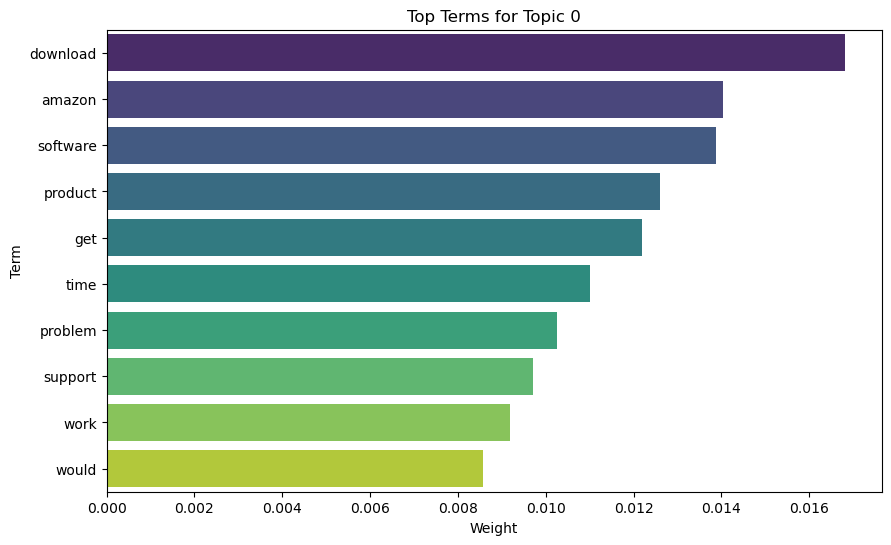

C:\Users\v-puritynjau\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


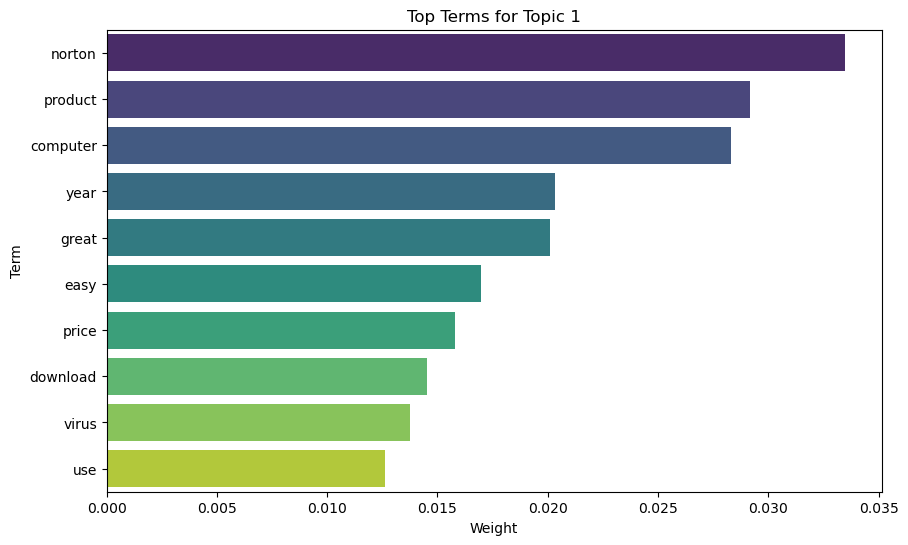

C:\Users\v-puritynjau\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


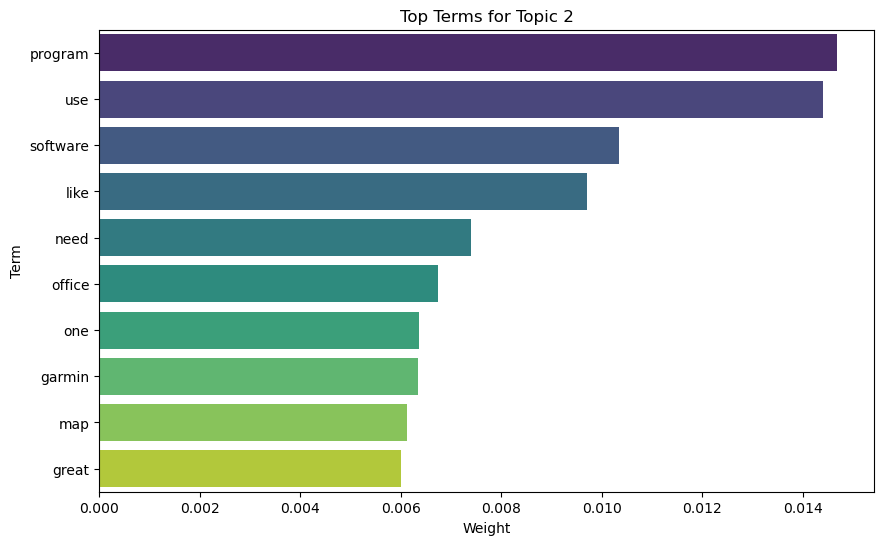

C:\Users\v-puritynjau\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


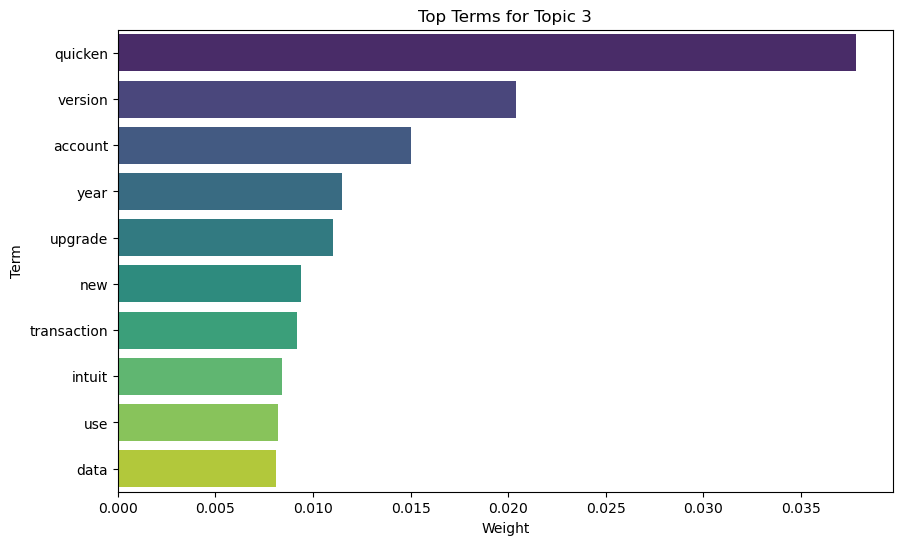

C:\Users\v-puritynjau\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


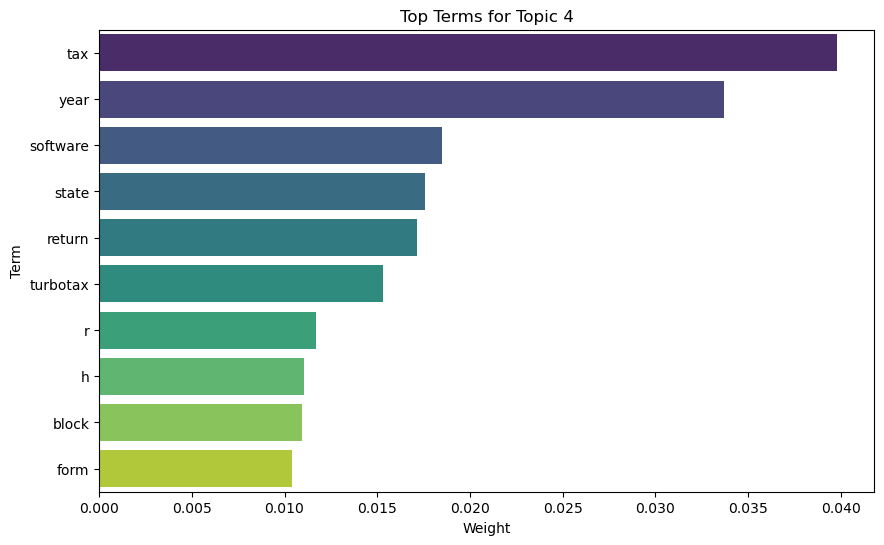

In [26]:
def plot_top_terms(ldamodel, num_topics):
    for i in range(num_topics):
        topic_words = ldamodel.show_topic(i, 10)
        words = [word for word, _ in topic_words]
        weights = [weight for _, weight in topic_words]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=weights, y=words, palette='viridis')
        plt.title(f'Top Terms for Topic {i}')
        plt.xlabel('Weight')
        plt.ylabel('Term')
        plt.show()

plot_top_terms(ldamodel, num_topics)
